Data Loading and Exploration

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

C:\Users\niroo\AppData\Local\Temp\ipykernel_31812\3371170394.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="Set2")


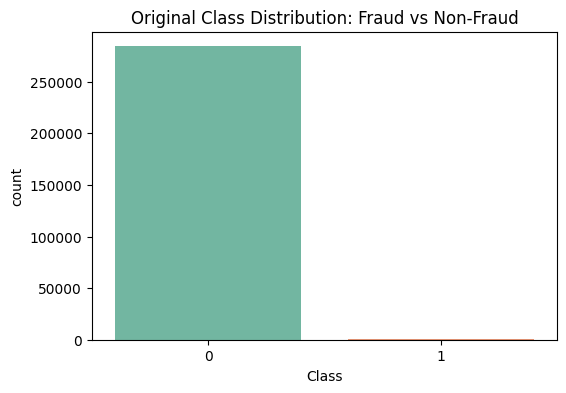

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("D:/fraud_dashboard_project/creditcard.csv")
print(df.head())
print(df['Class'].value_counts())

# Scale 'Amount' and 'Time'
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])
df['Time'] = scaler.fit_transform(df[['Time']])

# Features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

plt.figure(figsize=(6,4))
sns.countplot(x=y, palette="Set2")
plt.title("Original Class Distribution: Fraud vs Non-Fraud")
plt.show()


Balancing Classes and Feature Selection

Post-resampling: [227451 227451]
Optimal number of features: 28
Selected features: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V22', 'V23', 'V24', 'V26', 'V27', 'V28', 'Amount']


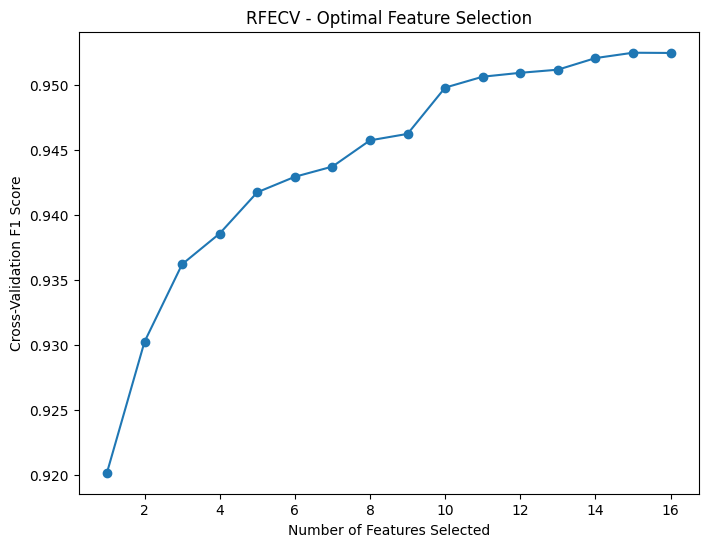

In [2]:
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

# Resampling (SMOTE + ADASYN for max accuracy)
X_res, y_res = SMOTE().fit_resample(X_train, y_train)
X_res, y_res = ADASYN().fit_resample(X_res, y_res)
print("Post-resampling:", np.bincount(y_res))

# RFECV for feature selection (5-fold CV, F1 metric)
lr = LogisticRegression(max_iter=2000, solver="lbfgs", n_jobs=-1)
rfecv = RFECV(estimator=lr, step=2, cv=5, scoring='f1', n_jobs=-1)
rfecv.fit(X_res, y_res)
print("Optimal number of features:", rfecv.n_features_)
print("Selected features:", list(X.columns[rfecv.support_]))

plt.figure(figsize=(8,6))
plt.title("RFECV - Optimal Feature Selection")
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validation F1 Score")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], marker="o")
plt.show()

X_res_selected = rfecv.transform(X_res)
X_test_selected = rfecv.transform(X_test)


Optuna-Based XGBoost Tuning

In [3]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay

# Train-validation split for Optuna
X_train_sel, X_val_sel, y_train_sel, y_val_sel = train_test_split(
    X_res_selected, y_res, test_size=0.2, stratify=y_res, random_state=42
)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "max_depth": trial.suggest_int("max_depth", 3, 14),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 8),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 20.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 20.0, log=True),
        "tree_method": "hist",
        "use_label_encoder": False,
        "eval_metric": "logloss",
        "random_state": 42,
    }
    model = XGBClassifier(**params)
    model.fit(X_train_sel, y_train_sel)
    preds = model.predict(X_val_sel)
    return f1_score(y_val_sel, preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)
print("Best params:", study.best_trial.params)

# Final model
best_params = study.best_trial.params
final_model = XGBClassifier(**best_params, tree_method="hist", use_label_encoder=False, eval_metric="logloss", random_state=42)
final_model.fit(X_res_selected, y_res)


[I 2025-10-14 11:00:05,654] A new study created in memory with name: no-name-16363227-2ce2-44f2-9872-9f36f4b778fc
C:\Users\niroo\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [11:00:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-10-14 11:00:18,603] Trial 0 finished with value: 0.9974643527513419 and parameters: {'n_estimators': 420, 'max_depth': 4, 'learning_rate': 0.04473956098441337, 'subsample': 0.9209905393919873, 'colsample_bytree': 0.7633278147211177, 'gamma': 5.669549356119133, 'min_child_weight': 8, 'reg_alpha': 0.002634005658172069, 'reg_lambda': 0.00356551169890818}. Best is trial 0 with value: 0.9974643527513419.
C:\Users\niroo\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [11:00:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use

Best params: {'n_estimators': 574, 'max_depth': 12, 'learning_rate': 0.030577150438292063, 'subsample': 0.8725207767041818, 'colsample_bytree': 0.8850351117279921, 'gamma': 0.8326187402868164, 'min_child_weight': 12, 'reg_alpha': 0.520767974136398, 'reg_lambda': 0.00012496107686634444}


C:\Users\niroo\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [11:25:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8850351117279921
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


Evaluation on Test Set

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.70      0.81      0.75        98

    accuracy                           1.00     56962
   macro avg       0.85      0.90      0.87     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy: 0.9991
MCC: 0.8384847146847502
Confusion Matrix:
 [[56830    34]
 [   19    79]]


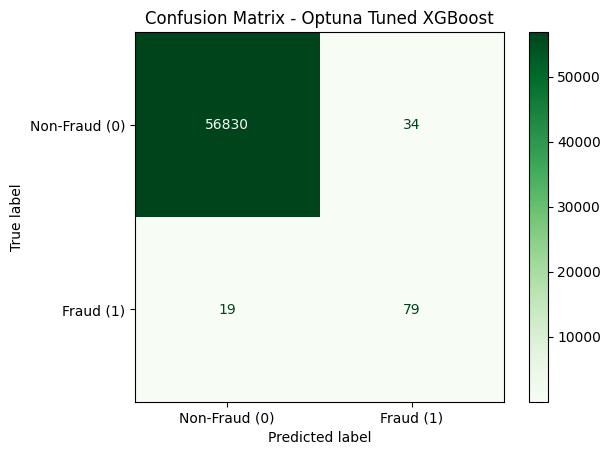

In [4]:
from sklearn.metrics import matthews_corrcoef
import numpy as np

y_probs = final_model.predict_proba(X_test_selected)[:, 1]

best_mcc = -1
best_thresh = 0.5
for thresh in np.linspace(0.1, 0.9, 81):
    y_pred_thresh = (y_probs >= thresh).astype(int)
    mcc = matthews_corrcoef(y_test, y_pred_thresh)
    if mcc > best_mcc:
        best_mcc = mcc
        best_thresh = thresh
y_pred = final_model.predict(X_test_selected)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy: {:.4f}".format(np.mean(y_test == y_pred)))
print("MCC:", best_mcc)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fraud (0)", "Fraud (1)"])
disp.plot(cmap="Greens", values_format="d")
plt.title("Confusion Matrix - Optuna Tuned XGBoost")
plt.show()


SHAP Explainability

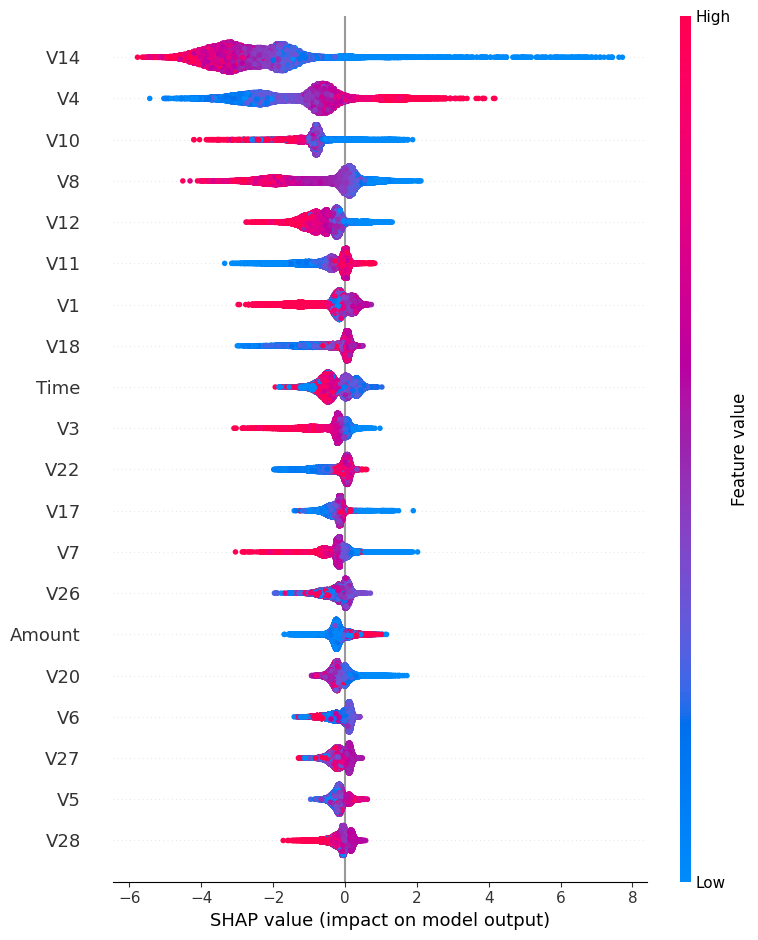

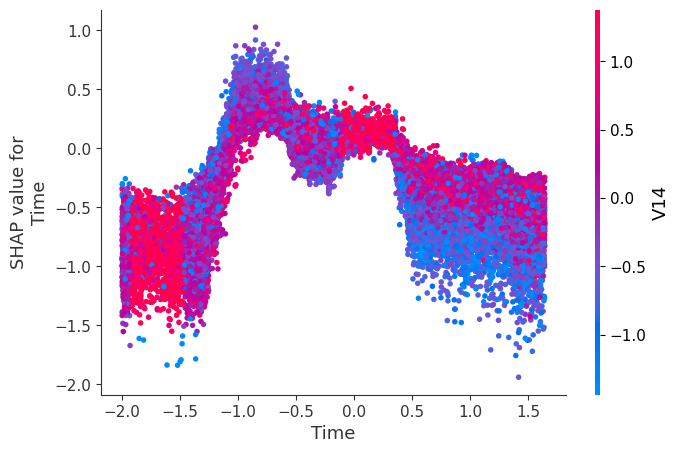

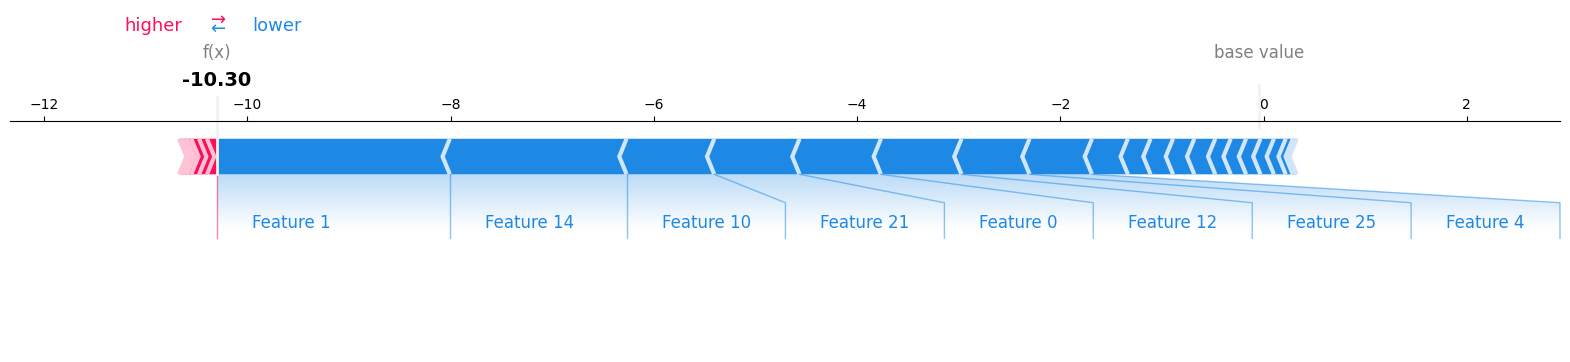

In [5]:
import shap

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_selected)

shap.summary_plot(shap_values, X_test_selected, feature_names=list(X.columns[rfecv.support_]))
top_feature = list(X.columns[rfecv.support_])[0]
shap.dependence_plot(top_feature, shap_values, X_test_selected, feature_names=list(X.columns[rfecv.support_]))

# Local explanation for one transaction
sample_idx = 10
shap.force_plot(explainer.expected_value, shap_values[sample_idx], matplotlib=True)


Save Model and Artifacts

In [8]:
import os

# Create directory if not exists
os.makedirs("D:/fraud_dashboard_project/models", exist_ok=True)
import joblib
joblib.dump(final_model, "D:/fraud_dashboard_project/models/fraud_xgb_model.pkl")
joblib.dump(rfecv, "D:/fraud_dashboard_project/models/feature_selector.pkl")
joblib.dump(scaler, "D:/fraud_dashboard_project/models/scaler.pkl")


['D:/fraud_dashboard_project/models/scaler.pkl']